In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import accuracy_score, confusion_matrix

In [4]:
df = pd.read_csv("abalone.csv")
df.head()

,Type,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [5]:
df["target"] = (df["Rings"] >= 10).astype(int)

df.drop(columns=["Rings"], inplace=True)

print(df["target"].value_counts())

target
0    2096
1    2081
Name: count, dtype: int64


In [6]:
df = pd.get_dummies(df, columns=["Type"], drop_first=True)
df.head()

,LongestShell,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,target,Type_I,Type_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,1,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,True,False


In [7]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
model = LogisticRegression(
    solver="liblinear",
    class_weight="balanced",
    random_state=42
)

model.fit(X_train_scaled, y_train)

y_val_prob = model.predict_proba(X_val_scaled)[:, 1]


In [10]:
thresholds = np.arange(0.05, 0.95, 0.01)

precision_list, recall_list, f1_list = [], [], []

for t in thresholds:
    y_pred = (y_val_prob >= t).astype(int)
    precision_list.append(precision_score(y_val, y_pred))
    recall_list.append(recall_score(y_val, y_pred))
    f1_list.append(f1_score(y_val, y_pred))

best_threshold = thresholds[np.argmax(f1_list)]
best_threshold

np.float64(0.4100000000000001)

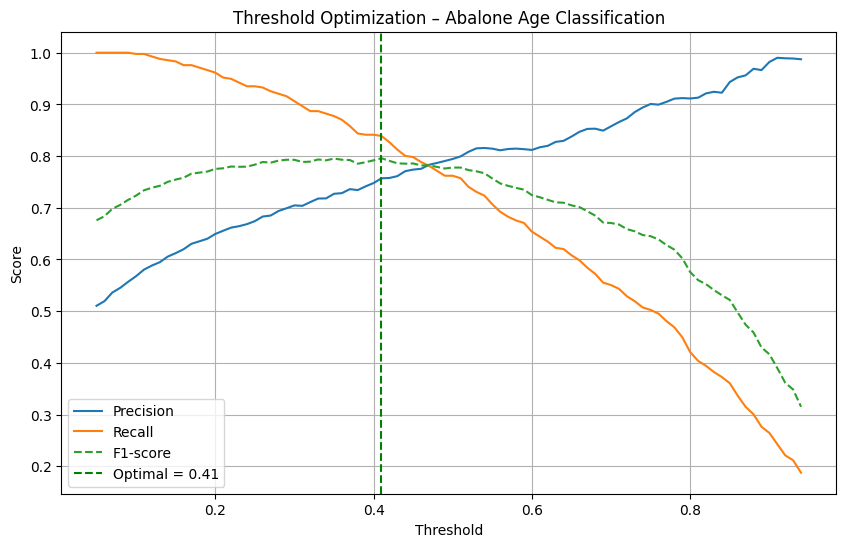

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label="Precision")
plt.plot(thresholds, recall_list, label="Recall")
plt.plot(thresholds, f1_list, linestyle="--", label="F1-score")
plt.axvline(best_threshold, color="green", linestyle="--",
            label=f"Optimal = {best_threshold:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Optimization – Abalone Age Classification")
plt.legend()
plt.grid(True)
plt.show()

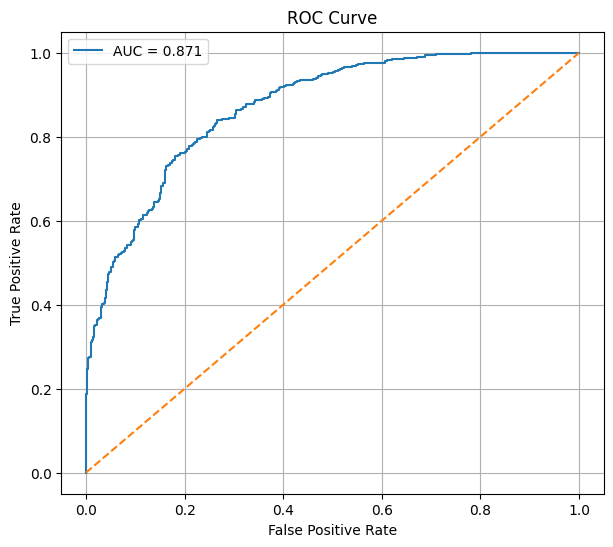

In [12]:
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc = roc_auc_score(y_val, y_val_prob)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

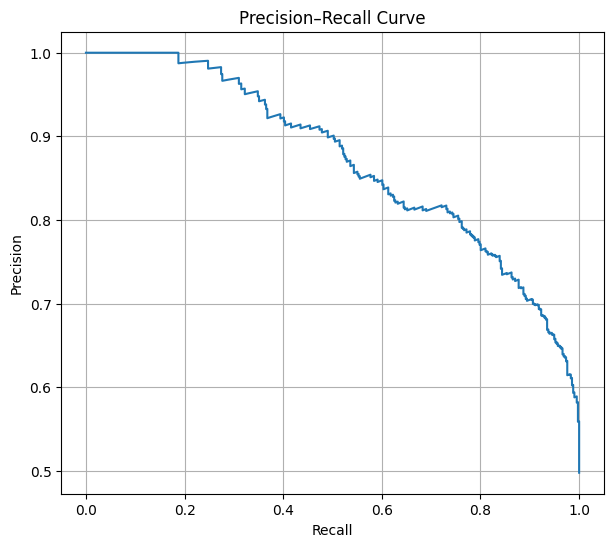

In [13]:
precision, recall, _ = precision_recall_curve(y_val, y_val_prob)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

In [14]:
y_final_pred = (y_val_prob >= best_threshold).astype(int)

print("Accuracy :", accuracy_score(y_val, y_final_pred))
print("Precision:", precision_score(y_val, y_final_pred))
print("Recall   :", recall_score(y_val, y_final_pred))
print("F1-score :", f1_score(y_val, y_final_pred))
print("ROC AUC  :", roc_auc)

Accuracy : 0.7858851674641149
Precision: 0.7570498915401301
Recall   : 0.8389423076923077
F1-score : 0.7958950969213227
ROC AUC  : 0.8709020146520147


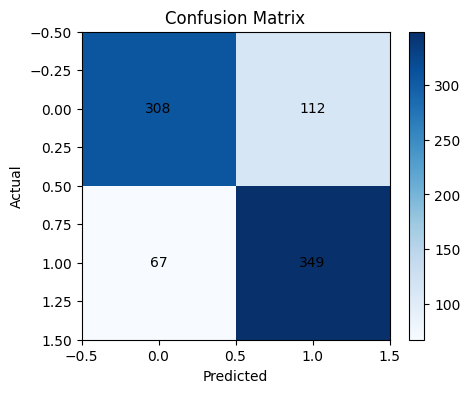

In [15]:
cm = confusion_matrix(y_val, y_final_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()